# NUFFT resampling

This notebook has the same purpose as ``fast_resampling.ipynb``, but this time we will use the package ``pynufft`` to make a real fast version. Here is the description of the original notebook:

In this notebook we will implement the method described in https://arxiv.org/pdf/1507.06174.pdf to resample univariate trigonometric polynomials. Let's say we have a trigonometric polynomial:
$$
f : x \mapsto \sum_{k=-n/2}^{n/2-1} \alpha_k \exp\left(i k x\right)
$$

and we know, for a set of points $(y_1, \dots, y_N) \in [-\pi, \pi]^N$, its values $f(y_1), \dots, f(y_N)$ with $N \geq n$. We want to estimate, for a new set of points $(x_1, \dots, x_M) \in [-\pi, \pi]^M$, the values taken by $f$. This can be done by first finding $\alpha$, by solving:
$$
\min_{\alpha \in \mathbb{C}^n} \sum_{j=1}^N \left|f(y_j) - \sum_{k=-n/2}^{n/2-1} \alpha_k \exp\left(i k y_j\right)\right|^2
$$

We use the following notations: $f = (f_1, \dots, f_N)$ and $A_{j, k} = \exp\left( i k y_j\right)$. We then have to solve:
$$
\min_{\alpha \in \mathbb{C}^n} \|f - A \alpha\|^2
$$

The solution satisfies:
$$
A^\dagger A \alpha = A^\dagger f
$$

which means we find alpha by inverting $A^\dagger A$ which takes $\mathcal{O}(n^2)$ but can be precomputed since we now in advance 

In [1]:
import numpy as np
from pynufft import NUFFT
from scipy.linalg import matmul_toeplitz, solve_toeplitz

from ppfft.resampling.fast_resampling import compute_A, compute_AdaggerA, compute_alpha, compute_inverse

In [2]:
n = 10
N = n + 1

y = 2 * np.pi * np.random.rand(N) - np.pi
A = compute_A(y, n)

alpha = np.random.rand(n)
f = np.random.rand(N)

The matrix $A$ computes a NUFFT at the positions $y$. We try to implement it with the ``pynufft`` package:

In [3]:
NufftObj = NUFFT()

NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(2 * n,), Jd=(6,))

0

In [4]:
np.max(np.abs(A @ alpha - NufftObj.forward(alpha)))

0.000811588294735411

In [5]:
np.max(np.abs(A.conj().T @ f - NufftObj.Kd * NufftObj.adjoint(f)))

0.0005902064374605996

# Performance test

In [6]:
n = 10000
N = n + 1

y = 2 * np.pi * np.random.rand(N) - np.pi
A = compute_A(y, n)

alpha = np.random.rand(n)
f = np.random.rand(N)

NufftObj = NUFFT()

NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(2 * n,), Jd=(6,))

0

In [7]:
%timeit A.conj().T @ f

434 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit NufftObj.Kd * NufftObj.adjoint(f)

712 µs ± 13 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Fast solver

In [9]:
def apply_inverse(c, v, r=None):
    """
    Computes T^-1 @ v using the Gohberg-Semencul decomposition of T^-1:

    T^-1 = (M1 @ M2 - M3 @ M4) / x0
    """

    e0 = np.zeros_like(c)
    e0[0] = 1

    e1 = np.zeros_like(c)
    e1[-1] = 1

    if r is None:
        x = solve_toeplitz(c, e0)
        y = solve_toeplitz(c, e1)

    else:
        x = solve_toeplitz((c, r), e0)
        y = solve_toeplitz((c, r), e1)

    x_a = np.zeros_like(x)
    x_a[0] = x[0]

    x_b = np.zeros_like(x)
    x_b[1::] = x[:0:-1]

    y_a = np.zeros_like(y)
    y_a[0] = y[-1]

    y_b = np.zeros_like(y)
    y_b[1::] = y[:-1]

    M1M2_v = matmul_toeplitz((x, x_a), matmul_toeplitz((y_a, y[::-1]), v))

    M3M4_v = matmul_toeplitz((y_b, np.zeros_like(y)), matmul_toeplitz((np.zeros_like(x), x_b), v)) 

    return (M1M2_v - M3M4_v) / x[0]

In [10]:
n = 10
N = n + 1

y = 2 * np.pi * np.random.rand(N) - np.pi
f = np.random.rand(N)

c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * y[None, :]))
AdagA = compute_AdaggerA(y, n)

print(np.max(np.abs(c - AdagA[:, 0])))

0.0


In [11]:
inv_AdagA = compute_inverse(c)
v = np.random.rand(n)

np.max(np.abs(inv_AdagA @ v - apply_inverse(c, v)))

4.705166569221804e-13

In [12]:
def toeplitz_min(c, adjoint, v, r=None):
    return apply_inverse(c, adjoint(v), r)

# Test

In [28]:
def trigo_poly(alpha, x):
    n = len(alpha)
    q_n, r_n = divmod(n, 2)
    k = np.arange(-q_n, q_n + r_n)
    kx = np.einsum("k,x->kx", k, x)
    return np.einsum("kx,k->x", np.exp(1j * kx), alpha)

In [29]:
def relative_error(x, true_x):
    return np.sum(np.abs(x - true_x)**2) / np.sum(np.abs(true_x)**2)

In [30]:
def true_adjoint(A):

    def aux(x):
        return A.conj().T @ x
    
    return aux

def nufft_adjoint(NufftObj):

    def aux(x):
        return NufftObj.Kd * NufftObj.adjoint(x)
    
    return aux

In [31]:
n = 10
N = n + 1

y = 2 * np.pi * np.linspace(0, 1, N, endpoint=False) - np.pi
A = compute_A(y, n)
alpha = np.random.rand(n)
f = trigo_poly(alpha, y)

NufftObj = NUFFT()
NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(2 * n,), Jd=(6,))
c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * y[None, :]))

In [32]:
sol_slow = compute_alpha(y, n, f)
print(relative_error(sol_slow, alpha))

sol_fast_true_adj = toeplitz_min(c, true_adjoint(A), f)
print(relative_error(sol_fast_true_adj, alpha))

sol_fast = toeplitz_min(c, nufft_adjoint(NufftObj), f)
print(relative_error(sol_fast, alpha))

1.188842112343224e-31
1.8017754815615823e-31
1.2206284400105513e-07


In [33]:
n = 1000
N = n + 1

y = 2 * np.pi * np.linspace(0, 1, N, endpoint=False) - np.pi
A = compute_A(y, n)
alpha = np.random.rand(n)
f = trigo_poly(alpha, y)

NufftObj = NUFFT()
NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(2 * n,), Jd=(6,))
c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * y[None, :]))

sol_slow = compute_alpha(y, n, f)
print(relative_error(sol_slow, alpha))

sol_fast_true_adj = toeplitz_min(c, true_adjoint(A), f)
print(relative_error(sol_fast_true_adj, alpha))

sol_fast = toeplitz_min(c, nufft_adjoint(NufftObj), f)
print(relative_error(sol_fast, alpha))

1.2377277095367333e-27
1.2342030519391317e-27
1.920091697394402e-11


In [34]:
from ppfft.resampling.fast_resampling import compute_alpha, fast_compute_alpha

In [52]:
n = 1000

y = 2 * np.pi * np.linspace(0, 1, n, endpoint=False) - np.pi
A = compute_A(y, n)
alpha = np.random.rand(n)
f = trigo_poly(alpha, y)

old_sol = compute_alpha(y, n, f)
new_sol = fast_compute_alpha(y, n, f)

In [37]:
print(relative_error(new_sol, alpha))
print(relative_error(old_sol, alpha))

1.57260971452913e-11
2.226159635646152e-27


In [53]:
import matplotlib.pyplot as plt

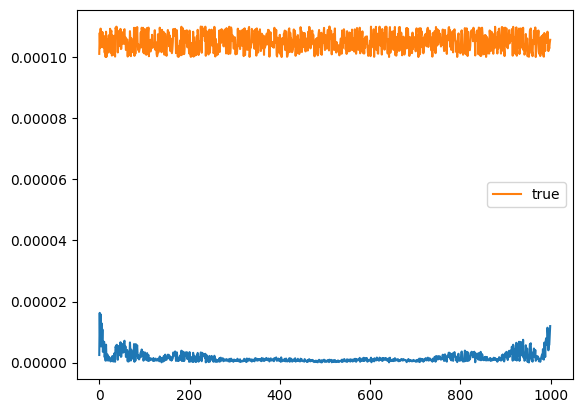

In [61]:
plt.plot(np.abs(new_sol - alpha))
plt.plot(1e-4 + 1e-5 * np.abs(alpha), label='true')
plt.legend()